# Librerías y rutas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import numpy as np   
import matplotlib.pyplot as plt

#Ruta
rutaPrincipal = '/content/drive/MyDrive/REDES_GENERATIVAS/Definitivo'

rutaEntrada = rutaPrincipal + '/dataset/noche'
rutaSalida = rutaPrincipal + '/dataset/dia'

#Ruta checkpoints
rutaCheckpoint = rutaPrincipal + '/checkpoints'

# Randomizar el dataset

In [ ]:
imgurls = !ls -1 '{rutaEntrada}'
print(imgurls)

n = 200 #Cantidad de imagenes usadas del dataset
train_n = round(n * 0.8)

randurls = np.copy(imgurls)

np.random.seed(23)
np.random.shuffle(randurls)

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

['100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg', '108.jpg', '109.jpg', '10.jpg', '110.jpg', '111.jpg', '112.jpg', '113.jpg', '114.jpg', '115.jpg', '116.jpg', '117.jpg', '118.jpg', '119.jpg', '11.jpg', '120.jpg', '121.jpg', '122.jpg', '123.jpg', '124.jpg', '125.jpg', '126.jpg', '127.jpg', '128.jpg', '129.jpg', '12.jpg', '130.jpg', '131.jpg', '132.jpg', '133.jpg', '134.jpg', '135.jpg', '136.jpg', '137.jpg', '138.jpg', '139.jpg', '13.jpg', '140.jpg', '141.jpg', '142.jpg', '143.jpg', '144.jpg', '145.jpg', '146.jpg', '147.jpg', '148.jpg', '149.jpg', '14.jpg', '150.jpg', '151.jpg', '152.jpg', '153.jpg', '154.jpg', '155.jpg', '156.jpg', '157.jpg', '158.jpg', '159.jpg', '15.jpg', '160.jpg', '161.jpg', '162.jpg', '163.jpg', '164.jpg', '165.jpg', '166.jpg', '167.jpg', '168.jpg', '169.jpg', '16.jpg', '170.jpg', '171.jpg', '172.jpg', '173.jpg', '174.jpg', '175.jpg', '176.jpg', '177.jpg', '178.jpg', '179.jpg', '17.jpg', '180.jpg', '181.jpg', '182.jpg', '183.j

# Manejo de dataset

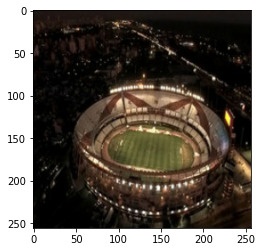

In [ ]:
#Preprocesamiento

IMG_WIDTH = 256
IMG_HEIGHT = 256

#Resize
def resize(inimg, tgimg, height, width):

  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg

#Normalizar al rango [-1, +1] la imagen.
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

#Data aumentation
@tf.function()
def random_jitter(inimg, tgimg): 

  inimg, tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg, tgimg], axis=0) #Apilar las imágenes.
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  inimg, tgimg = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:

    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

def load_image(filename, augment=True):
  
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(rutaEntrada + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(rutaSalida + '/' + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg

def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2)

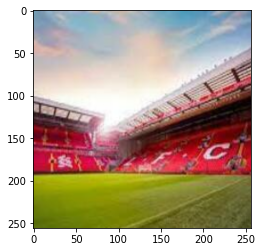

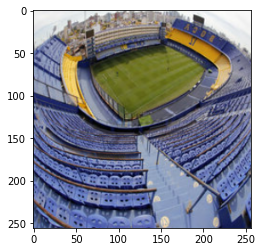

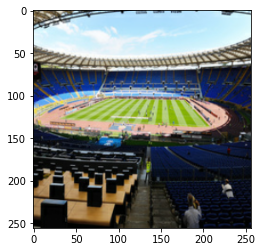

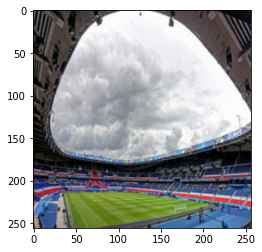

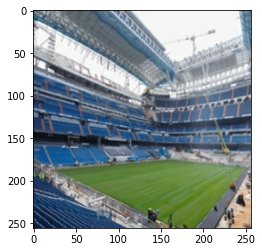

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for inimg, tgimg in train_dataset.take(5):
  plt.imshow(((tgimg[0, ...]) + 1) / 2)
  plt.show()

# Diseño de la arquitectura Pix2Pix

In [ ]:
from keras.layers import *
from keras.models import *

def downsample(filters, apply_batchnorm=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))

  if apply_batchnorm:
    result.add(BatchNormalization())

  result.add(LeakyReLU())

  return result

downsample(64)

In [ ]:
def upsample(filters, apply_dropout=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))

  result.add(BatchNormalization()) 

  if apply_dropout:

    result.add(Dropout(0.5))
  
  result.add(ReLU()) 

  return result

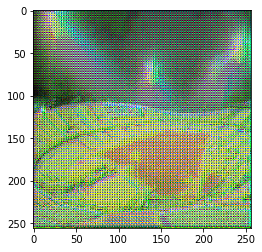

In [ ]:
from tensorflow.python.ops.numpy_ops.np_math_ops import outer
from tensorflow.python.ops.variables import initialize_all_variables

#Generador
def Generator():

  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack = [
    downsample(64, apply_batchnorm=False),
    downsample(128),
    downsample(256),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
  ]

  up_stack = [
     upsample(512, apply_dropout=True),
     upsample(512, apply_dropout=True),
     upsample(512, apply_dropout=True),
     upsample(512),
     upsample(256),
     upsample(128),
     upsample(64),         
  ]

  initializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters = 3,
                         kernel_size = 4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh")
  

  x = inputs
  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  for up, sk in zip(up_stack, s):
     
    x = up(x)
    x = concat([x, sk])

  last = last(x)

  return Model(inputs=inputs, outputs=last)

generator = Generator()
gen_output = generator(((inimg+1)*255), training=False)
plt.imshow(gen_output[0,...])

TensorShape([1, 16, 16, 1])

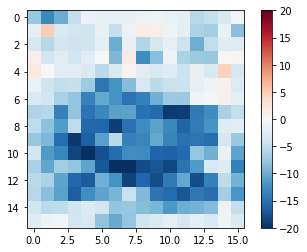

In [ ]:
#Discriminador
def Discriminator():

  ini = Input(shape=[None, None, 3], name = "input_img")
  gen = Input(shape=[None, None, 3], name = "gener_img")

  con = concatenate([ini ,gen])

  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)

  return Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator() 

disc_out = discriminator([((inimg+1)*255), gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
disc_out.shape                             

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#Perdida del discriminador
def discriminator_loss(disc_real_output, disc_generated_output):

  #Loss de las imagenes reales
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  #Loss de las imagenes falas
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  #Mean absolute error.
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [ ]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(rutaCheckpoint, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed() -> Esta línea se usa en caso de requerir la recuperación del modelo a partir de checkpoints (genera un error cuando se deja el método assert.consumed())

In [ ]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(rutaPrincipal + '/output/' + save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Imagen de Input', 'Imagen real', 'Imagen de predicción']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')

  plt.show()     

In [ ]:
@tf.function()
def train_step(input_image, target):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)


    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [ ]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):

    imgi = 0
    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi)+'/'+str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)

    imgi = 0  
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi += 1

    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)    

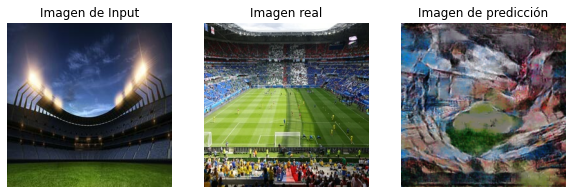

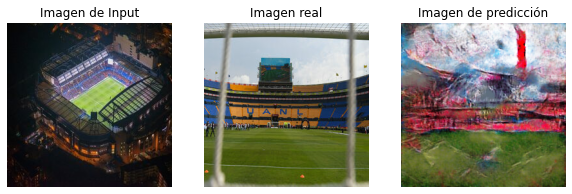

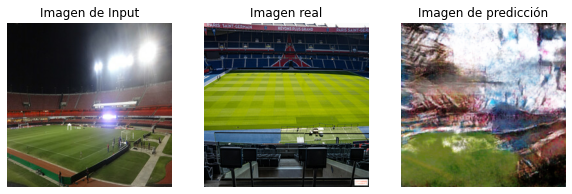

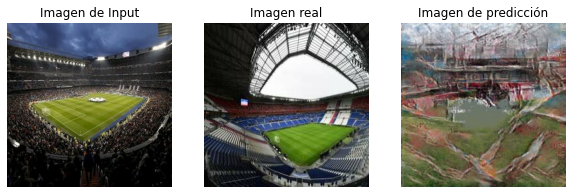

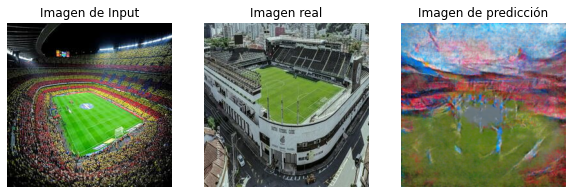

In [ ]:
#Realizar el entrenamiento de la red.
train(train_dataset, 500)

In [ ]:
#Ruta de guardado del modelo.
rutaModelo = '/content/drive/MyDrive/REDES_GENERATIVAS/Definitivo/modelo'
os.chdir(rutaModelo)
!pwd 

/content/drive/.shortcut-targets-by-id/1C27QPsW4RnoyPdzkXXnf0SLULNEtMAkV/REDES_GENERATIVAS/Definitivo/modelo


In [ ]:
#Compilar el modelo a partir del generador.
generator.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Guardar el modelo.
generator.save('modelo.h5')

# Predicción de nuevas imágenes

## Nuevos paths

In [ ]:
path ='/content/drive/MyDrive/REDES_GENERATIVAS/Definitivo'
rutaModelo = path + '/modelo/modelo.h5'
Modelo = load_model(rutaModelo)

rutaPred = path + '/val' #Ruta de las imágenes a predecir
rutaTarget = path + '/valTarget' # Ruta de las imágenes reales para realizar la comparación

## Reajustar tamaño de las imágenes originales a comparar

In [ ]:
import glob
import cv2
%cd /content/drive/MyDrive/REDES_GENERATIVAS/Definitivo

#Hacemos un ciclo for utilizando la librería glob para recuperar archivos/nombres de ruta que coincidan con un patrón específico.

for allpath in glob.glob(os.path.join(rutaTarget, '*')): #Lea todos los archivos dentro del path, sin importar el nombre
  print("Extrayendo el archivo: {}".format(allpath))
  try:

    lista = allpath.split("/") #Hacemos split para poder separar por "/"
    img = lista[6] #Obtenemos el último valor después del "/" que corresponde al nombre de la imagen con su formato.
    img = cv2.imread(img, cv2.IMREAD_COLOR) #Leemos la imagen mediante CV2.
    img = cv2.resize(img, (256,256), interpolation= cv2.INTER_LINEAR) #Reajustamos el tamaño de las imágenes a 128x128.

    cv2.imwrite(rutaTarget + '/' + lista[6], img)
    print('Tamaño de imagen reajustado. Imagen guardada en ', rutaTarget)

      
  except Exception as e: #En caso de que no pueda realizar el código anterior, arroje un error.
    print(e) #Imprime el error en cuestión.
    continue


/content/drive/.shortcut-targets-by-id/1C27QPsW4RnoyPdzkXXnf0SLULNEtMAkV/REDES_GENERATIVAS/Definitivo


In [ ]:
trainImagesUrls = !ls -1 "{rutaPred}"
testImagesUrls = !ls -1 "{rutaTarget}"

IMG_WIDTH = 256
IMG_HEIGHT = 256

#Se realiza el reescalado de las imágenes.
def resize(inimg, tgimg, height, width):

  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg

# Normalizar al rango [-1, +1] la imagen.
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

@tf.function()
# Se realiza el data augmentation: random crop + flip.
def random_jitter(inimg, tgimg):

  inimg, tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg, tgimg], axis=0) 
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  inimg, tgimg = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:

    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

def load_image(filename, augment=True):
  
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(rutaPred + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(rutaTarget + '/' + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg

#Función donde se carga la imagen de entrenamiento.
def load_train_image(filename):
  return load_image(filename, True)

#Función donde se carga la imagen de testeo.
def load_test_image(filename):
  return load_image(filename, False)

In [ ]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(path + '/output/' + save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      #Se obtienen los valores del pixel (entre 0 y 1) para plotearlo.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')

  plt.show()   

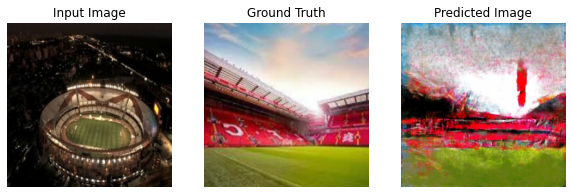

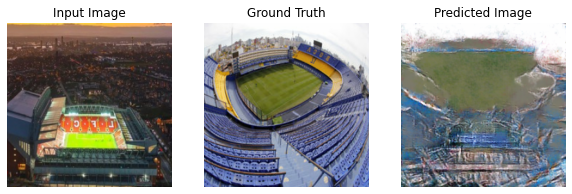

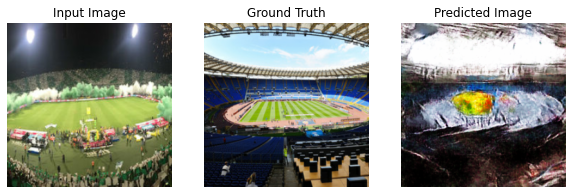

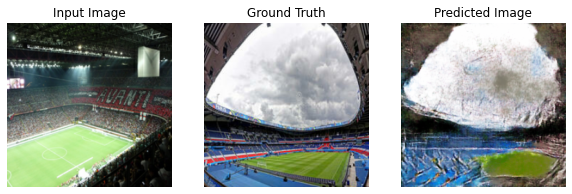

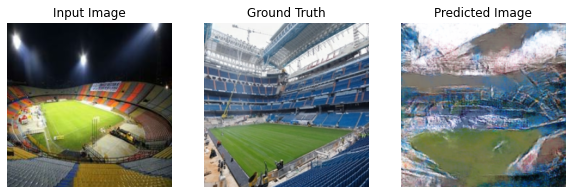

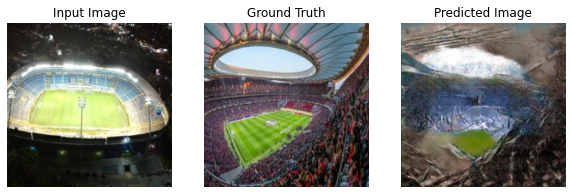

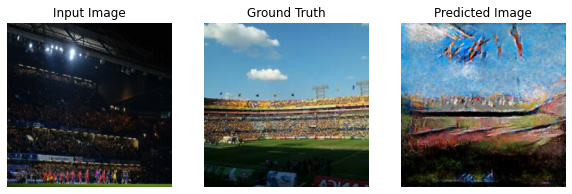

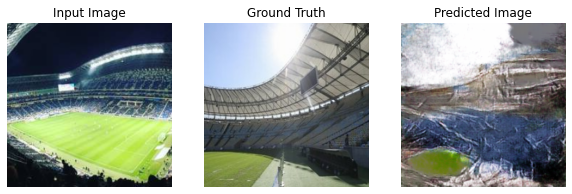

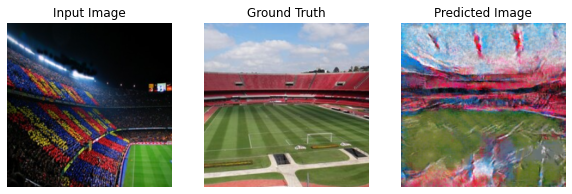

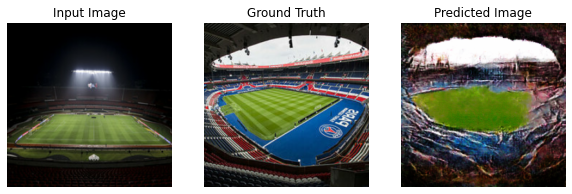

In [ ]:
for inp, tar in train_dataset.take(10):
  generate_images(Modelo, inp, tar)